<a href="https://colab.research.google.com/github/Ricardo-IA/Projeto_Ml/blob/main/Pj1/Projeto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importação dos pacotes:

In [1]:
from google.colab import files
uploaded = files.upload()

Saving 0.jpg to 0.jpg


In [8]:
image_dir = Path('/content/Dog e cat')

In [6]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

Create file DataFrame:

In [10]:
filepaths = list(image_dir.glob(r'**/*.jpg'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [11]:
image_df

,Filepath,Label
0,/content/Dog e cat/Dog/7.jpg,Dog
1,/content/Dog e cat/Dog/26.jpg,Dog
2,/content/Dog e cat/Dog/32.jpg,Dog
3,/content/Dog e cat/Dog/39.jpg,Dog
4,/content/Dog e cat/Dog/43.jpg,Dog
...,...,...
91,/content/Dog e cat/cat/46.jpg,cat
92,/content/Dog e cat/cat/6.jpg,cat
93,/content/Dog e cat/cat/8.jpg,cat
94,/content/Dog e cat/cat/5.jpg,cat


In [12]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

Load Image Data


In [13]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [14]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 54 validated image filenames belonging to 2 classes.
Found 13 validated image filenames belonging to 2 classes.
Found 29 validated image filenames belonging to 2 classes.


Training

In [15]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)


Epoch 1/100
2/2 [==============================] - 7s 2s/step - loss: 0.6923 - accuracy: 0.5556 - val_loss: 0.7005 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 2/100
2/2 [==============================] - 3s 2s/step - loss: 0.6908 - accuracy: 0.5370 - val_loss: 0.6995 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 3/100
2/2 [==============================] - 3s 2s/step - loss: 0.6936 - accuracy: 0.5370 - val_loss: 0.7041 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 4/100
2/2 [==============================] - 4s 2s/step - loss: 0.6900 - accuracy: 0.5370 - val_loss: 0.7043 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 5/100
2/2 [==============================] - 3s 2s/step - loss: 0.6906 - accuracy: 0.5370 - val_loss: 0.7047 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 6/100
2/2 [==============================] - 3s 1s/step - loss: 0.6898 - accuracy: 0.5370 - val_loss: 0.7052 - val_accuracy: 0.4615 - lr: 1.0000e-04
Epoch 7/100
2/2 [==============================] - 3s 2s/step - loss: 0.6897 - accuracy: 0

Results

In [16]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))


    Test Loss: 0.70027
Test Accuracy: 44.83%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: Und

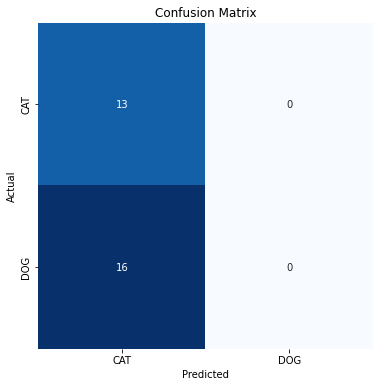

Classification Report:
----------------------
               precision    recall  f1-score   support

         CAT       0.45      1.00      0.62        13
         DOG       0.00      0.00      0.00        16

    accuracy                           0.45        29
   macro avg       0.22      0.50      0.31        29
weighted avg       0.20      0.45      0.28        29



In [17]:
predictions = (model.predict(test_images) >= 0.5).astype(np.int)

cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["CAT", "DOG"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.yticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)